In [11]:
%%time
# Data manipulation
import numpy as np
import pandas as pd

# Creating training and test sets
import sklearn

# File system management
import os.path

# Supress Warnings
import warnings
warnings.filterwarnings('ignore')

#training/test split
from sklearn.model_selection import StratifiedShuffleSplit, StratifiedKFold, ShuffleSplit

# run logistic regression and vary some parameters
from sklearn.linear_model import LogisticRegression
from sklearn import metrics as mt

# here we can change some of the parameters interactively
from ipywidgets import widgets as wd
from sklearn.model_selection import cross_val_score, cross_validate

#for weights standardization
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

from matplotlib import pyplot as plt

# Support vector machines
from sklearn.svm import SVC

from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score

Wall time: 0 ns


In [12]:
%%time
# Constants
#DATAPATH_BASE = 'https://machinelearningi.blob.core.windows.net/group-project/'
#DATAPATH_SAS_TOKEN = '?sv=2019-02-02&ss=bfqt&srt=sco&sp=rwdlacup&se=2020-04-27T11:12:37Z&st=2020-01-23T04:12:37Z&spr=https&sig=jpIpjrp8dIg9eyUyPpmgTe5yj9i1ZoCSru5kBVHcUO8%3D'
#DATAPATH_FILENAME = 'Arrest_Data_from_2010_to_Present.csv'
#DATAPATH_SMALL_FILENAME = 'Arrest_Data_from_2010_to_Present_Small.csv'

# Fully qualified paths ready to use
#DATA_SOURCE = "".join([DATAPATH_BASE, DATAPATH_FILENAME, DATAPATH_SAS_TOKEN])

# Options
#pd.set_option('float_format', '{:.2f}'.format)  # Reign in the scientific notation for reasonable values

# Load data for analysis; only read if needed because the import can take a long time
#try:
#    if len(df.index) < 1:
#        df_raw = pd.read_csv(DATA_SOURCE) # If we get here, the dataframe was empty
#except:   
#    df_raw = pd.read_csv(DATA_SOURCE) # If we get here, the dataframe did not exist

df_raw = pd.read_csv("Arrest_Data_From_2010_to_Present.csv", delim_whitespace = False)
#pd.read_csv('source.txt',header=0, delim_whitespace=True)
df = df_raw

print("The dataset has {:,} rows and {:,} columns".format(*df.shape))
    

The dataset has 1,324,973 rows and 17 columns
Wall time: 2.63 s


In [13]:
%%time
# Time - filter out 0 and missing
df = df[df['Time'] != 0]
df['Time'] = df['Time'].astype(str) 
df = df[df['Time'] != 'nan']

# Time - Convert float to string. Get rid of decimals. Replace missing or invalid values with '0000'.
df['Time'] = df['Time'].astype(str).str.split(".", expand = True)[0].replace(to_replace = ['2400','nan'], value = '0000') 

# Time - Fill time column with leading zeros to have 4 characters total
df['Time'] = df['Time'].apply(lambda x: '{0:0>4}'.format(x))

# Time - Add colon to Time values by converting attribute to a datetime variable 
df['Time'] = pd.to_datetime(df['Time'], format = '%H%M').dt.time

# Age - Drop the observations where Age is less than 16
df.drop(df[df['Age'] < 16].index, inplace = True) 

# Arrest Type Code - Drop the observations where Arrest Type Code = 'D'
df.drop(df[df['Arrest Type Code'] == 'D'].index, inplace = True) 

# Descent Code - Re-classify any descent not in (B,H,O,W) into 0
descent_list = ['B','H','O','W']
df['Descent Code'] = np.where(np.isin(df['Descent Code'],descent_list),df['Descent Code'],'O')

# Get hour
df['Hour'] = pd.to_datetime(df['Time'], format='%H:%M:%S').dt.hour

# Convert Arrest Date to datetime
df['Arrest Date'] = pd.to_datetime(df['Arrest Date'])

# Extract year, month, and day of week and add to dataframe as new attributes
#df['arrest_year']= df['Arrest Date'].dt.year
df['arrest_month']= df['Arrest Date'].dt.month
df['arrest_day_of_week'] = df['Arrest Date'].dt.weekday_name

# remove unecessary columns
df.drop(['Cross Street','Charge Description','Charge','Charge Group Description','Time',
         'Arrest Date','Report ID','Address','Area Name','Location'], axis=1, inplace=True)

# Change data types
df['Age'] = df['Age'].astype(np.int8)
df['Reporting District'] = df['Reporting District'].astype(np.str)
df['Area ID'] = df['Area ID'].astype(np.str)
df['Charge Group Code'] = df['Charge Group Code'].astype(np.str)
df['Hour'] = df['Hour'].astype(np.str)
#df['arrest_year'] = df['arrest_year'].astype(np.str)
df['arrest_month'] = df['arrest_month'].astype(np.str)
df['arrest_day_of_week'] = df['arrest_day_of_week'].astype(np.str)

df_lightgbm = df
# print clean dataset
df.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 1277176 entries, 0 to 1324972
Data columns (total 10 columns):
Area ID               1277176 non-null object
Reporting District    1277176 non-null object
Age                   1277176 non-null int8
Sex Code              1277176 non-null object
Descent Code          1277176 non-null object
Charge Group Code     1277176 non-null object
Arrest Type Code      1277176 non-null object
Hour                  1277176 non-null object
arrest_month          1277176 non-null object
arrest_day_of_week    1277176 non-null object
dtypes: int8(1), object(9)
memory usage: 98.7+ MB
Wall time: 10.5 s


In [14]:
%%time
# Create buckets for Age
df['age_range'] = pd.cut(df.Age,[16,25,35,45,55,65,75,1e6],4,labels=[0,1,2,3,4,5,6]) # this creates a new variable
df['age_range'] = df.age_range.astype(np.int)

# Replace the current Sex atribute with something slightly more intuitive and readable
df['IsMale'] = df['Sex Code']=='M' 
df.IsMale = df.IsMale.astype(np.int)

# Perform one-hot encoding of the categorical data "DOW"
tmp_df = pd.get_dummies(df['arrest_day_of_week'],prefix='DOW',drop_first=True)
df = pd.concat((df,tmp_df),axis=1) # add back into the dataframe

# Perform one-hot encoding of the categorical data "Area ID"
tmp_df = pd.get_dummies(df['Area ID'],prefix='Area',drop_first=True)
df = pd.concat((df,tmp_df),axis=1) # add back into the dataframe

# Perform one-hot encoding of the categorical data "Charge Group Code"
tmp_df = pd.get_dummies(df['Charge Group Code'],prefix='Charge',drop_first=True)
df = pd.concat((df,tmp_df),axis=1) # add back into the dataframe

# Perform one-hot encoding of the categorical data "Hour"
tmp_df = pd.get_dummies(df['Hour'],prefix='Hour',drop_first=True)
df = pd.concat((df,tmp_df),axis=1) # add back into the dataframe

# Perform one-hot encoding of the categorical data "Month"
tmp_df = pd.get_dummies(df['arrest_month'],prefix='Month',drop_first=True)
df = pd.concat((df,tmp_df),axis=1) # add back into the dataframe


Wall time: 3.08 s


In [15]:
%%time

df_arrest = df
df_descent = df

#Final encoding steps for Arrest Type Code classification dataset
# Encode Arrest Type Code as Categorical
cleanup_arrest = {"Arrest Type Code": {"F": 0, "M": 1, "I": 2, "O":3}}
df_arrest.replace(cleanup_arrest,inplace=True)

# Perform one-hot encoding of the categorical data "Descent Code"
tmp_df = pd.get_dummies(df_arrest['Descent Code'],prefix='Descent',drop_first=True)
df_arrest = pd.concat((df_arrest,tmp_df),axis=1) # add back into the dataframe

df_arrest.drop(['Sex Code','Descent Code','arrest_day_of_week','Area ID','Reporting District','Charge Group Code',
         'Age','Hour','arrest_month'], axis=1, inplace=True)

df_arrest.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1277176 entries, 0 to 1324972
Data columns (total 94 columns):
Arrest Type Code    1277176 non-null int64
age_range           1277176 non-null int32
IsMale              1277176 non-null int32
DOW_Monday          1277176 non-null uint8
DOW_Saturday        1277176 non-null uint8
DOW_Sunday          1277176 non-null uint8
DOW_Thursday        1277176 non-null uint8
DOW_Tuesday         1277176 non-null uint8
DOW_Wednesday       1277176 non-null uint8
Area_10             1277176 non-null uint8
Area_11             1277176 non-null uint8
Area_12             1277176 non-null uint8
Area_13             1277176 non-null uint8
Area_14             1277176 non-null uint8
Area_15             1277176 non-null uint8
Area_16             1277176 non-null uint8
Area_17             1277176 non-null uint8
Area_18             1277176 non-null uint8
Area_19             1277176 non-null uint8
Area_2              1277176 non-null uint8
Area_20             1277176

In [25]:
#Final encoding steps for Descent Code classification dataset
cleanup_descent = {"Descent Code": {"B": 0, "H": 1, "W": 2, "O":3}}
df_descent.replace(cleanup_descent,inplace=True)

# Perform one-hot encoding of the categorical data "Arrest Type Code"
tmp_df = pd.get_dummies(df_descent['Arrest Type Code'],prefix='Arrest',drop_first=True)
df_descent = pd.concat((df_descent,tmp_df),axis=1) #add back to the dataframe

df_descent.drop(['Sex Code','Arrest Type Code','arrest_day_of_week','Area ID','Reporting District','Charge Group Code',
         'Age','Hour','arrest_month'], axis=1, inplace=True)

df_descent.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1277176 entries, 0 to 1324972
Data columns (total 94 columns):
Descent Code     1277176 non-null int64
age_range        1277176 non-null int32
IsMale           1277176 non-null int32
DOW_Monday       1277176 non-null uint8
DOW_Saturday     1277176 non-null uint8
DOW_Sunday       1277176 non-null uint8
DOW_Thursday     1277176 non-null uint8
DOW_Tuesday      1277176 non-null uint8
DOW_Wednesday    1277176 non-null uint8
Area_10          1277176 non-null uint8
Area_11          1277176 non-null uint8
Area_12          1277176 non-null uint8
Area_13          1277176 non-null uint8
Area_14          1277176 non-null uint8
Area_15          1277176 non-null uint8
Area_16          1277176 non-null uint8
Area_17          1277176 non-null uint8
Area_18          1277176 non-null uint8
Area_19          1277176 non-null uint8
Area_2           1277176 non-null uint8
Area_20          1277176 non-null uint8
Area_21          1277176 non-null uint8
Area_3 

### Grid Search for KNN classifier (Arrest Type Code)

In [6]:
#sampling data for time constraints
df_arrest_small = pd.DataFrame.sample(df_arrest, frac = .025, random_state = 1234)
len(df_arrest_small)

31929

In [57]:
%%time
#multi parameter grid search

k_range = list(range(1, 25))
weight_options = ['uniform', 'distance']

param_grid = dict(n_neighbors = k_range, weights = weight_options)
print(param_grid)

{'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24], 'weights': ['uniform', 'distance']}
Wall time: 0 ns


In [58]:
%%time
grid = GridSearchCV(knn, param_grid, cv = 10, scoring = 'accuracy', return_train_score = False)
grid.fit(X, y)
results = pd.DataFrame(grid.cv_results_)[['mean_test_score', 'std_test_score', 'params']]
results.sort_values(by = ["mean_test_score"], ascending = False)

Wall time: 1h 28min 42s


,mean_test_score,std_test_score,params
46,0.757869,0.006855,"{'n_neighbors': 24, 'weights': 'uniform'}"
38,0.757399,0.005321,"{'n_neighbors': 20, 'weights': 'uniform'}"
30,0.757149,0.006903,"{'n_neighbors': 16, 'weights': 'uniform'}"
47,0.756835,0.006759,"{'n_neighbors': 24, 'weights': 'distance'}"
40,0.756804,0.006361,"{'n_neighbors': 21, 'weights': 'uniform'}"
42,0.756742,0.006156,"{'n_neighbors': 22, 'weights': 'uniform'}"
39,0.756554,0.005718,"{'n_neighbors': 20, 'weights': 'distance'}"
43,0.756303,0.005521,"{'n_neighbors': 22, 'weights': 'distance'}"
34,0.756240,0.006939,"{'n_neighbors': 18, 'weights': 'uniform'}"
41,0.756240,0.006925,"{'n_neighbors': 21, 'weights': 'distance'}"


Looking at the output, it seems n = 24 with uniform weights is the best performer

No handles with labels found to put in legend.


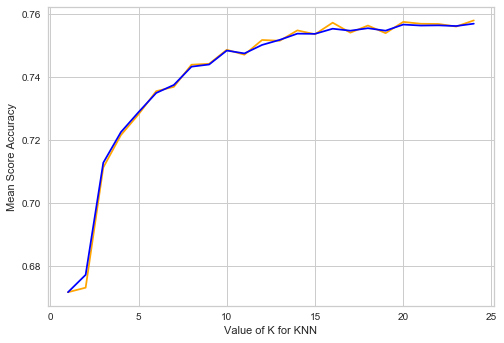

In [59]:

#score_dist = pd.DataFrame(grid.cv_results_)['mean_test_score']

weight_u = pd.DataFrame(grid.cv_results_)[pd.DataFrame(grid.cv_results_)['param_weights'] == 'uniform']#results from uniform parameter weights
weight_d = pd.DataFrame(grid.cv_results_)[pd.DataFrame(grid.cv_results_)['param_weights'] == 'distance']

plt.plot(k_range, weight_u['mean_test_score'], color = 'orange')
plt.plot(k_range, weight_d['mean_test_score'], color = 'blue')
plt.xlabel('Value of K for KNN')
plt.ylabel('Mean Score Accuracy')
plt.legend()

In [9]:
%%time 

from sklearn.model_selection import train_test_split
from sklearn.metrics import average_precision_score
from sklearn.metrics import confusion_matrix 

X = df_arrest_small.drop(['Arrest Type Code'], axis = 1) #data
y = df_arrest_small['Arrest Type Code'] #target

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 1234)

knn = KNeighborsClassifier(n_neighbors = 24, weights = 'uniform').fit(X_train, y_train) 
  
# accuracy on X_test 
accuracy = knn.score(X_test, y_test) 
print("accuracy  = ", accuracy) 
  
# creating a confusion matrix 
knn_predictions = knn.predict(X_test)  
cm = confusion_matrix(y_test, knn_predictions) 
print("confusion matrix \n", cm)

from sklearn.metrics import precision_recall_fscore_support
a = precision_recall_fscore_support(y_test, knn_predictions, average='micro')
b = precision_recall_fscore_support(y_test, knn_predictions, average='weighted')

print('micro average precision/recall/fscore = ', a)

print('\nweighted average precision/recall/fscore = ', b)


accuracy  =  0.7628711010898158
confusion matrix 
 [[1517  952    0    2]
 [ 454 4530   15    0]
 [  12  296   43    0]
 [  36  126    0    0]]
micro average precision/recall/fscore =  (0.7628711010898158, 0.7628711010898158, 0.7628711010898158, None)

weighted average precision/recall/fscore =  (0.7456413161270123, 0.7628711010898158, 0.7387582108409431, None)
Wall time: 49.9 s


76% accuracy is adequate for the purpose of demonstration. Additional test runs on the next highest ranked Grid search recommended parameters scored slightly lower, around 74%, but were omitted for brevity's sake. Grid Search iterating on the possible parameters appears to be at the more efficient than doing so manually. Limitations include computational time limits on longer classifiers like KNN due to the large number of parameters to run, even on a sample of the data. 

### Grid Search for KNN classifier (Descent Code)

In [26]:
%%time
#sampling data for time constraints
df_descent_small = pd.DataFrame.sample(df_descent, frac = .005, random_state = 1234)
len(df_descent_small)

Wall time: 42.9 ms


6386

In [28]:
%%time
from sklearn.model_selection import RandomizedSearchCV 

knn = KNeighborsClassifier(n_neighbors=24, weights='uniform')

k_range = list(range(1, 31))
param_grid = dict(n_neighbors = k_range)

y = df_descent_small['Descent Code'] #target
X = df_descent_small.drop(['Descent Code'], axis = 1) #data


#Randomized search CV grid search
k_range = list(range(1, 25))
weight_options = ['uniform', 'distance']

param_grid = dict(n_neighbors = k_range, weights = weight_options)

rand = RandomizedSearchCV(knn, param_grid, cv=10, scoring='accuracy', n_iter=10, random_state=5)

rand.fit(X, y)

results = pd.DataFrame(rand.cv_results_)[['mean_test_score', 'std_test_score', 'params']]
results.sort_values(by = ["mean_test_score"], ascending = False)

Wall time: 38.2 s


,mean_test_score,std_test_score,params
9,0.511431,0.020660,"{'weights': 'distance', 'n_neighbors': 23}"
7,0.507360,0.021876,"{'weights': 'uniform', 'n_neighbors': 22}"
0,0.506420,0.021897,"{'weights': 'distance', 'n_neighbors': 15}"
1,0.500783,0.022446,"{'weights': 'uniform', 'n_neighbors': 17}"
5,0.498434,0.024814,"{'weights': 'uniform', 'n_neighbors': 14}"
3,0.495615,0.022529,"{'weights': 'distance', 'n_neighbors': 9}"
4,0.494989,0.023966,"{'weights': 'distance', 'n_neighbors': 10}"
2,0.460069,0.027691,"{'weights': 'uniform', 'n_neighbors': 4}"
6,0.421391,0.022662,"{'weights': 'uniform', 'n_neighbors': 2}"
8,0.416536,0.027111,"{'weights': 'distance', 'n_neighbors': 2}"


No handles with labels found to put in legend.


Wall time: 19.9 ms


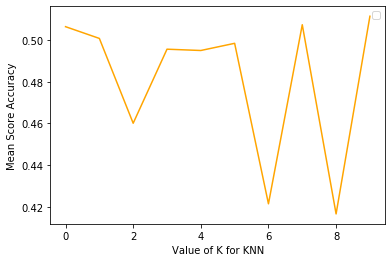

In [34]:
%%time
#results by weight type

weight_u = pd.DataFrame(rand.cv_results_)[pd.DataFrame(rand.cv_results_)['param_weights'] == 'uniform']#results from uniform parameter weights
weight_d = pd.DataFrame(rand.cv_results_)[pd.DataFrame(rand.cv_results_)['param_weights'] == 'distance']


plt.plot( pd.DataFrame(rand.cv_results_)['mean_test_score'], color = 'orange')
#plt.plot(k_range, weight_d['mean_test_score'], color = 'blue')
plt.xlabel('Value of K for KNN')
plt.ylabel('Mean Score Accuracy')
plt.legend()

In [35]:
%%time 

#implementing grid search selected classifier parameters
from sklearn.model_selection import train_test_split
from sklearn.metrics import average_precision_score
from sklearn.metrics import confusion_matrix 

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 1234)

knn = KNeighborsClassifier(n_neighbors = 23, weights = 'uniform').fit(X_train, y_train) 
  
# accuracy on X_test 
accuracy = knn.score(X_test, y_test) 
print("accuracy  = ", accuracy) 
  
# creating a confusion matrix 
knn_predictions = knn.predict(X_test)  
cm = confusion_matrix(y_test, knn_predictions) 
print("confusion matrix \n", cm)

from sklearn.metrics import precision_recall_fscore_support
a = precision_recall_fscore_support(y_test, knn_predictions, average='micro')
b = precision_recall_fscore_support(y_test, knn_predictions, average='weighted')

print('micro average precision/recall/fscore = ', a)

print('\nweighted average precision/recall/fscore = ', b)


accuracy  =  0.5128365685660614
confusion matrix 
 [[212 208  24   0]
 [136 567  33   0]
 [105 178  40   0]
 [ 16  69   9   0]]
micro average precision/recall/fscore =  (0.5128365685660614, 0.5128365685660614, 0.5128365685660614, None)

weighted average precision/recall/fscore =  (0.4576799749012331, 0.5128365685660614, 0.4641112968558727, None)
Wall time: 1.76 s


Randomized Search CV drastically cuts down computational time, but doesn't make quite as clean a picture as running through every possible permutation. The lower accuracy be attributed to both the random nature of the classifier parameters that were explored and the multicategorical nature of classifying the four possible descent codes. 

11. Deployment

(5 points)

How useful is your model for interested parties (i.e., the companies or organizations that might want to use it for prediction)? How would you measure the model's value if it was used by these parties? How would your deploy your model for interested parties? What other data should be collected? How often would the model need to be updated, etc.?

Model deployment - although minority report style predictive modeling would be (cool), the amount of cleaning necessary to process the data would likely bottleneck the process for a single county, let alone large municipalities. An ideal use would be obtaining relevant retrospective analysis on things that could influence anything intersecting the data gathered during the arrests. Changes in demographic, criminal definition, (literally anything on a macro sociological scale if you abstract out far enough) can possibly be reflected in arrest data types. The ability to condense wide scale sociological change into easily understandable and verifiable conclusions would be the primary function of this type of retrospective analysis, although (other stuff) Conclusions like “The new highschool police mentorship program in this county has reduced arrests in high school age people by 15% ” or “This new spanish language program for officers has reduced hispanic misdemeanors by 10%” would be valuable information for citizens, politicians, and civil servants who have influence in the process of creating/implementing such civil programs.  




### Model Comparison 

#### Task 1 - Classifying Arrest Type Code

|Model| AUC | Precision | Recall | F1 Score | Support | 
| :-- | :-- | :-- | :-- | :-- | :-- |
| "model 1" |     |     |     |     | 
| "model 2" |     |     |     |     |
| "model 3" |     |     |     |     |

#### Task 2 - Classifying Descent Code

|Model| AUC | Precision | Recall | F1 Score | Support | 
| :-- | :-- | :-- | :-- | :-- | :-- |
| "model 1" |     |     |     |     | 
| "model 2" |     |     |     |     |
| "model 3" |     |     |     |     |

(ROC/AUC) was chosen as the comparison metric for the 3 models on both tasks because (reasons go here). 

For classifying arrest code, the (winning model type) achieved a final ROC of (roc here),  (slightly/much) larger  compared to the others. This may be due to the unbalanced nature of the data; 60% misdemeanors, 30% felonies, less than 10% infractions and other.  This may fit the structural and computational assumptions of (winning model) better than (losing models). (evidence to back that up)

For Classifying Descent Code, the (winning model type) had a final ROC of (ROC here), (much/ only marginally) better than (the other two, with (roc2, roc3)). Descent code was also a fairly unbalanced dataset, with almost 50% of the arrests recorded as Hispanic, 30% black, and 15% white. (winning model) operates on (assumptions of winning model) which are more closely reflected in the data than (the assumptions of the other models).  

